In [20]:
from IPython.display import Image 
import glob
from matplotlib import pyplot as plt
from skimage.feature import hog
import cv2 as cv
import numpy as np

In [213]:
from skimage.transform import rescale

In [ ]:
images = glob.glob('object-detection-crowdai/*.jpg')

In [187]:
def get_full_images(images):
    for image in images:
        yield(cv.imread(image, 0))

In [506]:
def get_next_image(im):
    image = im.next()
    image_2 = rescale(image, 1.0/4.0)
    plt.imshow(image_2)
    return image_2

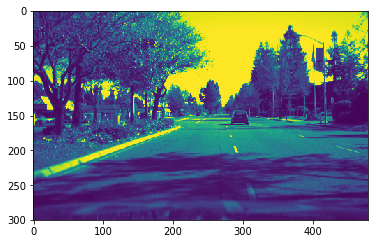

In [507]:
im = get_full_images(images)
image = get_next_image(im)
height, width = image.shape

In [509]:
def slide_win(image):
    w_start = width/4
    w_end = width*3/4
    h_start = height/4
    h_end = height*3/4
    win = 64
    for h in range(h_start, h_end,5):
        for w in range(w_start, w_end,5):
            sub_image = image[h:h+win, w: w+win]
            yield sub_image

In [532]:
sub_images = slide_win(image)

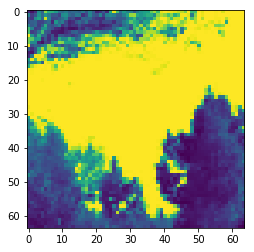

In [567]:
img = sub_images.next()
plt.imshow(img)

/home/cylam/workspace/virtualenv/pyenv2/local/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/cylam/workspace/virtualenv/pyenv2/local/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/cylam/workspace/virtualenv/pyenv2/local/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your da

prediction:  0
prediction:  0
prediction:  0
prediction:  0
prediction:  0
prediction:  0
prediction:  0
prediction:  0
prediction:  0
prediction:  0
prediction:  0
prediction:  0
prediction:  0
prediction:  0
prediction:  0
prediction:  0
prediction:  0
prediction:  0
prediction:  0
prediction:  0
prediction:  0
prediction:  0
prediction:  0
prediction:  0
prediction:  0
prediction:  0
prediction:  0
prediction:  1


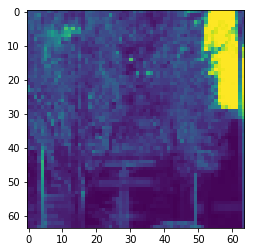

In [574]:
for img in sub_images:
    pred = clf.predict(hog(img))
    print "prediction: ", pred[0]
    if pred[0] == 1:
        plt.imshow(img)
        break

In [79]:
im = np.float32(im)/255

In [16]:
gx = cv.Sobel(im, cv.CV_32F, 1, 0, ksize=1)

In [17]:
gy = cv.Sobel(im, cv.CV_32F, 0, 1, ksize=1)

In [40]:
mag , angle = cv.cartToPolar(gx, gy, angleInDegrees=True)

(<matplotlib.axes._subplots.AxesSubplot at 0x7f8dcc308f90>,
 <matplotlib.image.AxesImage at 0x7f8dcc263b90>)

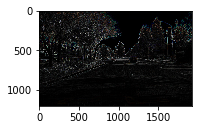

In [43]:
plt.subplot(2,2,1),plt.imshow(mag,cmap = 'gray')

### read training data 

In [82]:
from skimage.feature import hog
from skimage import data, color, exposure

In [112]:
vehicles = glob.glob('OwnCollection/vehicles/MiddleClose/*.png')

In [113]:
scenes = glob.glob('OwnCollection/non-vehicles/MiddleClose/*.png')

In [114]:
train_imgs = vehicles + scenes

In [128]:
labels = [1]*len(vehicles) + [0]*len(scenes)

In [134]:
hog_features = []

In [136]:
for img_file in train_imgs:
    im = cv.imread(img_file, 0)
    feature = hog(im)
    hog_features.append(feature)

In [137]:
from sklearn.svm import SVC

In [179]:
def cal_class_weight(labels):
    label_freq = Counter(labels)
    class_weight = {}
    total = 0
    for k, v in label_freq.items():
        weight = np.log(v)/float(v+3)
        total += weight 
        class_weight[k] = v
    return class_weight

In [180]:
clf = SVC(class_weight=cal_class_weight(labels))

In [181]:
clf.fit(hog_features, labels)

SVC(C=1.0, cache_size=200, class_weight={0: 975, 1: 500}, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [182]:
predicts = clf.predict(hog_features)

In [183]:
correct, incorrect = 0, 0

In [184]:
for pred , label in zip(predicts, labels):
    if pred == label:
        correct += 1
    else:
        incorrect += 1

In [185]:
correct

1458

In [186]:
incorrect

17

In [151]:
from collections import Counter

In [575]:
import pickle

In [579]:
pickle.dump(clf, open('svm_classifier.pkl', 'wb'))